In [1]:
import numpy as np
import pandas as pd

In [2]:
df_labels = pd.read_csv("../dados/mimic/mimic-cxr-2.0.0-chexpert.csv")
df_labels.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


# Metricas RAG

In [24]:
results = np.load('artifacts/resultados_aux/results_06.npy', allow_pickle=True)
results_txt = np.load('artifacts/resultados/results_txt.npy', allow_pickle=True)
results_img = np.load('artifacts/resultados/results_img.npy', allow_pickle=True)

mean_metrics = {
    m: np.mean([res[m] for res in results])
    for m in results[0]
}
mean_metrics["RAG"] = 'Estudo'

mean_metrics_txt = {
    m: np.mean([res[m] for res in results_txt])
    for m in results_txt[0]
}
mean_metrics_txt["RAG"] = 'Texto'

mean_metrics_img = {
    m: np.mean([res[m] for res in results_img])
    for m in results_img[0]
}
mean_metrics_img["RAG"] = 'Imagem'

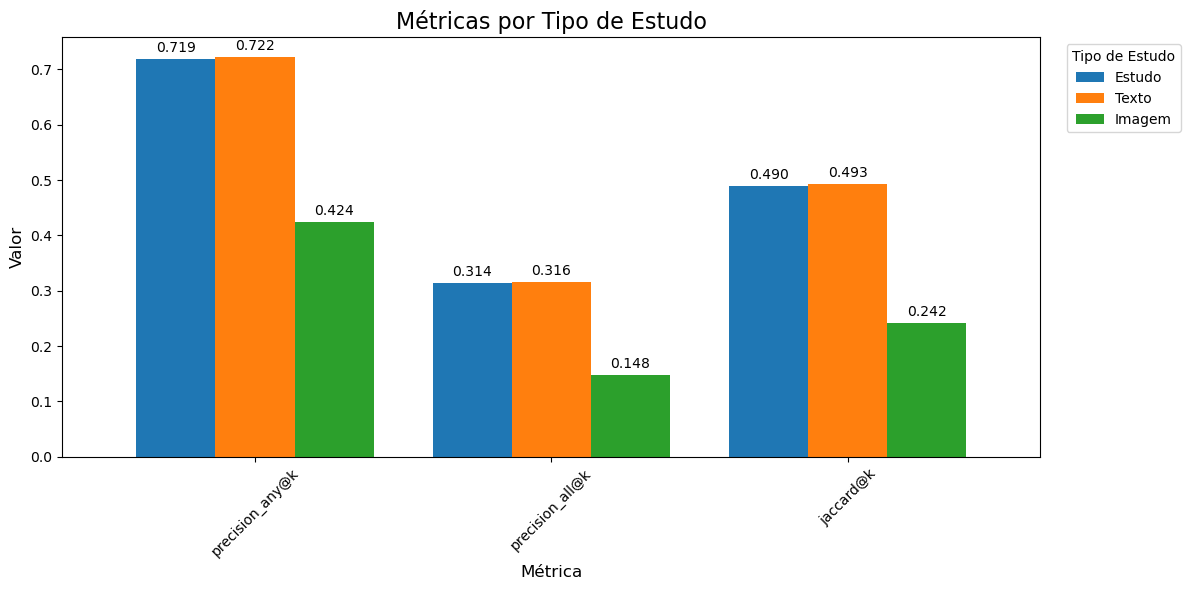

In [32]:
df_rag = pd.DataFrame([mean_metrics, mean_metrics_txt, mean_metrics_img])

df_rag = df_rag[['precision@k', 'jaccard_1@k', 'jaccard@k', 'RAG']]
df_rag.columns = ['precision_any@k', 'precision_all@k', 'jaccard@k', 'RAG']

import matplotlib.pyplot as plt

# Preparar dados: transposiçao para ter métricas no eixo X
df_plot = df_rag.set_index('RAG').T

plt.figure(figsize=(12, 6))
ax = plt.gca()

df_plot.plot(kind='bar', ax=ax, width=0.8)

plt.title("Métricas por Tipo de Estudo", fontsize=16)
plt.xlabel("Métrica", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.legend(title="Tipo de Estudo", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xticks(rotation=45)

# Adicionar anotações com os valores das barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.tight_layout()
plt.show()

In [92]:
count=0
count_txt=0

comp_results_list = []
for i in range(len(results)):
    if results[i]['jaccard_1@k'] > results_txt[i]['jaccard_1@k']:
        count+=1
        comp_results = {}
        comp_results['estudo'] = results[i]['jaccard_1@k']
        comp_results['texto'] = results_txt[i]['jaccard_1@k']

        comp_results_list.append(comp_results)
    
    if results_txt[i]['jaccard_1@k'] > results[i]['jaccard_1@k']:
        count_txt+=1

count_all = 0
for i in range(len(comp_results_list)):
    if comp_results_list[i]['texto'] == 0:
        count_all += 1

print(f'''Dos {len(results)} estudos, o RAG usando estudo retornou mais casos relevantes (all) para {count} laudos. ({round(count/len(results),3)}%).
      \nO RAG usando texto retornou mais casos relevantes para {count_txt} ({round(count_txt/len(results),3)}%).
      \nDos {count} laudos que o RAG com estudo retornou mais casos relevantes, {count_all} não retornaram nenhum caso relevante usando texto. 
      ''')

Dos 227835 estudos, o RAG usando estudo retornou mais casos relevantes (all) para 23805 laudos. (0.104%).
      
O RAG usando texto retornou mais casos relevantes para 25955 (0.114%).
      
Dos 23805 laudos que o RAG com estudo retornou mais casos relevantes, 7696 não retornaram nenhum caso relevante usando texto. 
      


# Metricas Classificador

In [13]:
y_pred = np.load('artifacts/resultados/y_pred.npy', allow_pickle = True)
y_true = np.load('artifacts/resultados/y_true.npy', allow_pickle = True)
y_pred_txt = np.load('artifacts/resultados/y_pred_txt.npy', allow_pickle = True)
y_true_txt = np.load('artifacts/resultados/y_true_txt.npy', allow_pickle = True)
y_pred_img = np.load('artifacts/resultados/y_pred_img.npy', allow_pickle = True)
y_true_img = np.load('artifacts/resultados/y_true_img.npy', allow_pickle = True)

In [14]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
binary_cols = [col for col in df_labels.columns if col not in ['subject_id', 'study_id']]
report = classification_report(y_pred, y_true, target_names = binary_cols, output_dict=True)
report_txt = classification_report(y_pred_txt, y_true_txt, target_names = binary_cols, output_dict=True)
report_img = classification_report(y_pred_img, y_true_img, target_names = binary_cols, output_dict=True)

In [16]:
reports = {
    "Estudo": report,
    "Texto": report_txt,
    "Imagem": report_img,
}

In [18]:
import pandas as pd

model_dfs = []

for model_name, rep in reports.items():
    # Transformar em DataFrame
    df = pd.DataFrame(rep).T
    
    # tirar linhas agregadas, ficar só com as classes (normalmente são strings dos labels)
    df = df[~df.index.isin(["accuracy", "macro avg", "weighted avg"])]
    
    # manter só precision e recall
    df = df[["precision", "recall", "f1-score"]]
    
    # adicionar nível de coluna com o nome do modelo
    df.columns = pd.MultiIndex.from_product([df.columns, [model_name]])
    
    model_dfs.append(df)

# Juntar tudo nas classes
metrics_df = pd.concat(model_dfs, axis=1)

# print(metrics_df)


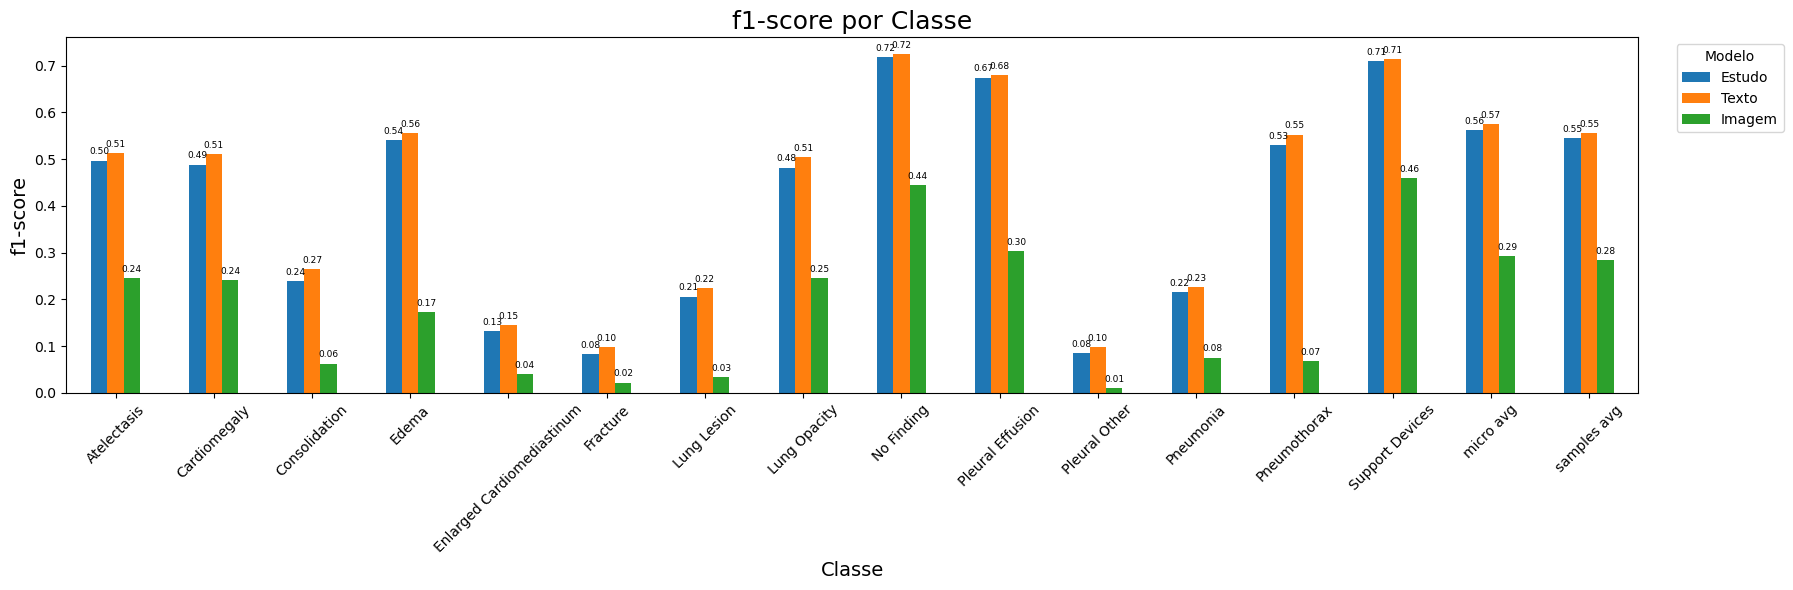

In [47]:
import matplotlib.pyplot as plt

precision_df = metrics_df.xs("f1-score", level=0, axis=1)

plt.figure(figsize=(18, 6))        # controla o tamanho
ax = plt.gca()                     # cria um eixo manual

precision_df.plot(
    kind="bar",
    ax=ax                          # força o pandas a usar ESTE eixo
)

plt.title("f1-score por Classe", fontsize=18)
plt.xlabel("Classe", fontsize=14)
plt.ylabel("f1-score", fontsize=14)

# Rotacionar a legenda
leg = plt.legend(title="Modelo", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.xticks(rotation=45)
plt.tight_layout()

# Adicionar anotações com os valores das barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize = 6.5)

plt.show()


# Checa labels dos jaccard = 1

In [77]:
from src.f_utils.embedding_utils import load_embeddings, extract_embedding_single_study, extract_embeddings_from_img, extract_embeddings_from_text, _extract_findings
emb_per_image = load_embeddings("artifacts/img_embeddings/embeddings_per_image.npy")
metadata = load_embeddings("artifacts/img_embeddings/image_metadata.npy")

✅ Embeddings carregados com sucesso!
📊 Formato dos dados: <class 'numpy.ndarray'>
📊 Shape: (377110,)
✅ Embeddings carregados com sucesso!
📊 Formato dos dados: <class 'numpy.ndarray'>
📊 Shape: (377110, 3)


In [76]:
def build_study_dataset(
        emb_per_image, 
        study_ids_path="artifacts/embeddings/study_ids.npy", 
        patient_ids_path="artifacts/embeddings/patient_ids.npy",
        text_emb_path="artifacts/embeddings/e_text.npy",
        labels_path="../dados/mimic/mimic-cxr-2.0.0-chexpert.csv"
    ):
    """
    Agrupa embeddings de imagens por estudo e combina com embeddings de texto e labels.
    
    Args:
        emb_per_image: lista de dicionários com embeddings por imagem
        study_ids_path: caminho para arquivo com IDs dos estudos
        patient_ids_path: caminho para arquivo com IDs dos pacientes
        text_emb_path: caminho para arquivo com embeddings de texto
        labels_path: caminho para arquivo CSV com labels CheXpert
    
    Returns:
        Lista de dicionários, um por estudo
    """
    import pandas as pd
    
    # Carregar dados alinhados por índice
    study_ids = load_embeddings(study_ids_path)
    patient_ids = load_embeddings(patient_ids_path)
    text_embeddings = load_embeddings(text_emb_path)
    
    # Carregar labels
    df_labels = pd.read_csv(labels_path)
    
    # Identificar colunas de labels (excluindo subject_id e study_id)
    label_columns = [col for col in df_labels.columns if col not in ['subject_id', 'study_id']]
    
    # Criar mapeamento study_id -> labels
    study_labels_dict = {}
    for _, row in df_labels.iterrows():
        study_id = 's' + str(int(row['study_id']))
        # Pegar labels onde o valor é 1
        labels = [col for col in label_columns if row[col] == 1.0]
        study_labels_dict[study_id] = labels
    
    # Criar mapeamento study_id -> index
    study_id_to_index = {sid: idx for idx, sid in enumerate(study_ids)}
    
    # Agrupar imagens por study_id
    from collections import defaultdict
    studies_dict = defaultdict(lambda: {
        'files_images': [],
        'embedding_images': []
    })
    
    for img_data in emb_per_image:
        study_id = img_data['study_id']
        studies_dict[study_id]['files_images'].append(img_data['image_name'])
        studies_dict[study_id]['embedding_images'].append(img_data['embedding_image'])
        studies_dict[study_id]['patient_id'] = img_data['patient_id']
    
    # Construir lista final de estudos
    result = []
    for study_id, data in studies_dict.items():
        # Buscar o índice do estudo
        if study_id not in study_id_to_index:
            print(f"⚠️ Study ID {study_id} não encontrado nos arquivos de embeddings")
            continue
            
        study_idx = study_id_to_index[study_id]
        
        study_dict = {
            "study_index": study_idx,
            "study_id": study_id,
            "patient_id": patient_ids[study_idx],
            "files_images": data['files_images'],
            "embedding_images": data['embedding_images'],
            "file_text": f"{study_id}.txt",
            "embedding_text": text_embeddings[study_idx],
            "study_labels": study_labels_dict.get(study_id, [])  # Labels do estudo ou lista vazia
        }
        result.append(study_dict)
    
    print(f"✅ {len(result)} estudos processados")
    return result

In [78]:
studies_dataset = build_study_dataset(emb_per_image)
print(f"\n\nTotal de estudos: {len(studies_dataset)}")
print(f"Exemplo: {studies_dataset[0]}")

✅ Embeddings carregados com sucesso!
📊 Formato dos dados: <class 'numpy.ndarray'>
📊 Shape: (227835,)
✅ Embeddings carregados com sucesso!
📊 Formato dos dados: <class 'numpy.ndarray'>
📊 Shape: (227835,)
✅ Embeddings carregados com sucesso!
📊 Formato dos dados: <class 'numpy.ndarray'>
📊 Shape: (227835, 1152)
✅ 227835 estudos processados


Total de estudos: 227835
Exemplo: {'study_index': 0, 'study_id': 's50414267', 'patient_id': 'p10000032', 'files_images': ['02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg', '174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962.jpg'], 'embedding_images': [array([-0.02441736,  0.03465954,  0.00766411, ..., -0.01386673,
        0.06212181,  0.01484995], dtype=float32), array([-0.03161281,  0.03163843,  0.00890976, ..., -0.01544448,
        0.05352064,  0.01552592], dtype=float32)], 'file_text': 's50414267.txt', 'embedding_text': array([-0.01413504,  0.01464215, -0.02659141, ..., -0.03464624,
       -0.07638288, -0.01550421], dtype=float32), 'study_labels': ['No F

In [94]:
labels = []
for i in range(len(results)):
    if results_txt[i]['jaccard_1@k'] > 0:
        labels.append(studies_dataset[i]['study_labels'])
print('Top 10 labels com pelo menos um retorno com caso relevante (all)')
print(pd.Series(labels).value_counts(normalize=True).head(10))

display(pd.DataFrame(pd.Series(labels).value_counts(normalize=True).head(10)))

labels = []
for i in range(len(results)):
    if results_txt[i]['jaccard_1@k'] == 1:
        labels.append(studies_dataset[i]['study_labels'])
print('\n\n')
print('Top 10 labels com todos retornos com caso relevante (all)')
print(pd.Series(labels).value_counts(normalize=True).head(10))

Top 10 labels com pelo menos um retorno com caso relevante (all)
[No Finding]                       0.507120
[No Finding, Support Devices]      0.064118
[Lung Opacity]                     0.046628
[Cardiomegaly]                     0.041402
[Atelectasis]                      0.026353
[Pleural Effusion]                 0.020705
[Cardiomegaly, Support Devices]    0.019931
[Atelectasis, Pleural Effusion]    0.015722
[Lung Opacity, Support Devices]    0.013189
[Atelectasis, Support Devices]     0.012297
Name: proportion, dtype: float64


,proportion
[No Finding],0.507120
"[No Finding, Support Devices]",0.064118
[Lung Opacity],0.046628
[Cardiomegaly],0.041402
[Atelectasis],0.026353
[Pleural Effusion],0.020705
"[Cardiomegaly, Support Devices]",0.019931
"[Atelectasis, Pleural Effusion]",0.015722
"[Lung Opacity, Support Devices]",0.013189
"[Atelectasis, Support Devices]",0.012297





Top 10 labels com todos retornos com caso relevante (all)
[No Finding]                       0.914830
[No Finding, Support Devices]      0.036209
[Cardiomegaly]                     0.018930
[Cardiomegaly, Support Devices]    0.006656
[Lung Opacity, Support Devices]    0.002316
[Pneumothorax]                     0.002236
[Pleural Effusion]                 0.001970
[Atelectasis]                      0.001837
[Lung Opacity]                     0.001518
[Pneumothorax, Support Devices]    0.001491
Name: proportion, dtype: float64


In [ ]:
[No Finding]                       0.507120
[No Finding, Support Devices]      0.064118
[Lung Opacity]                     0.046628
[Cardiomegaly]                     0.041402
[Atelectasis]                      0.026353
[Pleural Effusion]                 0.020705
[Cardiomegaly, Support Devices]    0.019931
[Atelectasis, Pleural Effusion]    0.015722
[Lung Opacity, Support Devices]    0.013189
[Atelectasis, Support Devices]     0.012297